# Training Neural Networks

The network we built in the previous part isn't so smart, it doesn't know anything about our handwritten digits. Neural networks with non-linear activations work like universal function approximators. There is some function that maps your input to the output. For example, images of handwritten digits to class probabilities. The power of neural networks is that we can train them to approximate this function, and basically any function given enough data and compute time.

<img src="assets/function_approx.png" width=500px>

At first the network is naive, it doesn't know the function mapping the inputs to the outputs. We train the network by showing it examples of real data, then adjusting the network parameters such that it approximates this function.

To find these parameters, we need to know how poorly the network is predicting the real outputs. For this we calculate a **loss function** (also called the cost), a measure of our prediction error. For example, the mean squared loss is often used in regression and binary classification problems

$$
\ell = \frac{1}{2n}\sum_i^n{\left(y_i - \hat{y}_i\right)^2}
$$

where $n$ is the number of training examples, $y_i$ are the true labels, and $\hat{y}_i$ are the predicted labels.

By minimizing this loss with respect to the network parameters, we can find configurations where the loss is at a minimum and the network is able to predict the correct labels with high accuracy. We find this minimum using a process called **gradient descent**. The gradient is the slope of the loss function and points in the direction of fastest change. To get to the minimum in the least amount of time, we then want to follow the gradient (downwards). You can think of this like descending a mountain by following the steepest slope to the base.

<img src='assets/gradient_descent.png' width=350px>

## Backpropagation

For single layer networks, gradient descent is simple to implement. However, it's more complicated for deeper, multilayer neural networks like the one we've built. Complicated enough that it took about 30 years before researchers figured out how to train multilayer networks, although it's straightforward once you learn about it. 

This is done through **backpropagation** which is really just an application of the chain rule from calculus. It's easiest to understand if we convert a two layer network into a graph representation.

<img src='assets/w1_backprop_graph.png' width=400px>

In the forward pass through the network, our data and operations go from right to left here. To train the weights with gradient descent, we propagate the gradient of the cost backwards through the network. Mathematically, this is really just calculating the gradient of the loss with respect to the weights using the chain rule.

$$
\frac{\partial \ell}{\partial w_1} = \frac{\partial l_1}{\partial w_1} \frac{\partial s}{\partial l_1} \frac{\partial l_2}{\partial s} \frac{\partial \ell}{\partial l_2}
$$

We update our weights using this gradient with some learning rate $\alpha$. 

$$
w^\prime = w - \alpha \frac{\partial \ell}{\partial w}
$$

The learning rate is set such that the weight update steps are small enough that the iterative method settles in a minimum.

The first thing we need to do for training is define our loss function. In PyTorch, you'll usually see this as `criterion`. Here we're using softmax output, so we want to use `criterion = nn.CrossEntropyLoss()` as our loss. Later when training, you use `loss = criterion(output, targets)` to calculate the actual loss.

We also need to define the optimizer we're using, SGD or Adam, or something along those lines. Here I'll just use SGD with `torch.optim.SGD`, passing in the network parameters and the learning rate.

## Autograd

Torch provides a module, `autograd`, for automatically calculating the gradient of tensors. It does this by keeping track of operations performed on tensors. To make sure PyTorch keeps track of operations on a tensor and calculates the gradients, you need to set `requires_grad` on a tensor. You can do this at creation with the `requires_grad` keyword, or at any time with `x.requires_grad_(True)`.

You can turn off gradients for a block of code with the `torch.no_grad()` content:
```python
x = torch.zeros(1, requires_grad=True)
>>> with torch.no_grad():
...     y = x * 2
>>> y.requires_grad
False
```

Also, you can turn on or off gradients altogether with `torch.set_grad_enabled(True|False)`.

The gradients are computed with respect to some variable `z` with `z.backward()`. This does a backward pass through the operations that created `z`.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from collections import OrderedDict

import numpy as np
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

import helper

In [2]:
x = torch.randn(2,2, requires_grad=True)
print(x)

tensor([[ 1.0020,  0.8200],
        [ 0.8813,  1.4125]])


In [3]:
y = x**2
print(y)

tensor([[ 1.0040,  0.6724],
        [ 0.7767,  1.9952]])


Below we can see the operation that created `y`, a power operation `PowBackward0`.

In [4]:
## grad_fn shows the function that generated this variable
print(y.grad_fn)

The autgrad module keeps track of these operations and knows how to calculate the gradient for each one. In this way, it's able to calculate the gradients for a chain of operations, with respect to any one tensor. Let's reduce the tensor `y` to a scalar value, the mean.

In [5]:
z = y.mean()
print(z)

tensor(1.1121)


You can check the gradients for `x` and `y` but they are empty currently.

In [6]:
print(x.grad)

None


To calculate the gradients, you need to run the `.backward` method on a Variable, `z` for example. This will calculate the gradient for `z` with respect to `x`

$$
\frac{\partial z}{\partial x} = \frac{\partial}{\partial x}\left[\frac{1}{n}\sum_i^n x_i^2\right] = \frac{x}{2}
$$

In [7]:
z.backward()
print(x.grad)
print(x/2)

tensor([[ 0.5010,  0.4100],
        [ 0.4407,  0.7063]])
tensor([[ 0.5010,  0.4100],
        [ 0.4407,  0.7063]])


These gradients calculations are particularly useful for neural networks. For training we need the gradients of the weights with respect to the cost. With PyTorch, we run data forward through the network to calculate the cost, then, go backwards to calculate the gradients with respect to the cost. Once we have the gradients we can make a gradient descent step. 

## Get the data and define the network

The same as we saw in part 3, we'll load the MNIST dataset and define our network.

In [8]:
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                             ])
# Download and load the training data
trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

I'll build a network with `nn.Sequential` here. Only difference from the last part is I'm not actually using softmax on the output, but instead just using the raw output from the last layer. This is because the output from softmax is a probability distribution. Often, the output will have values really close to zero or really close to one. Due to [inaccuracies with representing numbers as floating points](https://docs.python.org/3/tutorial/floatingpoint.html), computations with a softmax output can lose accuracy and become unstable. To get around this, we'll use the raw output, called the **logits**, to calculate the loss.

In [9]:
# Hyperparameters for our network
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

# Build a feed-forward network
model = nn.Sequential(OrderedDict([
                      ('fc1', nn.Linear(input_size, hidden_sizes[0])),
                      ('relu1', nn.ReLU()),
                      ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
                      ('relu2', nn.ReLU()),
                      ('logits', nn.Linear(hidden_sizes[1], output_size))]))

## Training the network!

The first thing we need to do for training is define our loss function. In PyTorch, you'll usually see this as `criterion`. Here we're using softmax output, so we want to use `criterion = nn.CrossEntropyLoss()` as our loss. Later when training, you use `loss = criterion(output, targets)` to calculate the actual loss.

We also need to define the optimizer we're using, SGD or Adam, or something along those lines. Here I'll just use SGD with `torch.optim.SGD`, passing in the network parameters and the learning rate.

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

First, let's consider just one learning step before looping through all the data. The general process with PyTorch:

* Make a forward pass through the network to get the logits 
* Use the logits to calculate the loss
* Perform a backward pass through the network with `loss.backward()` to calculate the gradients
* Take a step with the optimizer to update the weights

Below I'll go through one training step and print out the weights and gradients so you can see how it changes.

In [13]:
print('Initial weights - ', model.fc1.weight)

images, labels = next(iter(trainloader))
images.resize_(64, 784)

# Clear the gradients, do this because gradients are accumulated
optimizer.zero_grad()

# Forward pass, then backward pass, then update weights
output = model.forward(images)
loss = criterion(output, labels)
loss.backward()
print('Gradient -', model.fc1.weight.grad)
optimizer.step()

Initial weights -  Parameter containing:
tensor(1.00000e-02 *
       [[ 0.0533, -0.4544,  2.7985,  ...,  3.4426,  3.0057, -2.1494],
        [ 1.3741,  0.7443, -2.0451,  ...,  1.2414, -1.0602,  2.4259],
        [-1.3149,  1.1927, -0.7107,  ...,  3.0063, -1.7802, -0.9433],
        ...,
        [ 2.3942,  3.4971,  2.9493,  ...,  1.1155, -1.8062, -2.6216],
        [-2.3545, -0.1671, -1.0136,  ...,  1.9638,  3.4373, -1.0215],
        [ 1.9277, -2.8281,  3.4197,  ...,  1.8021,  1.7838, -3.3088]])
Gradient - tensor(1.00000e-02 *
       [[ 0.0852,  0.0852,  0.0852,  ...,  0.0852,  0.0852,  0.0852],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1017,  0.1017,  0.1017,  ...,  0.1017,  0.1017,  0.1017],
        ...,
        [ 0.0185,  0.0185,  0.0185,  ...,  0.0185,  0.0185,  0.0185],
        [-0.2097, -0.2097, -0.2097,  ..., -0.2097, -0.2097, -0.2097],
        [-0.0527, -0.0527, -0.0527,  ..., -0.0527, -0.0527, -0.0527]])


In [14]:
print('Updated weights - ', model.fc1.weight)

Updated weights -  Parameter containing:
tensor([[ 5.2451e-04, -4.5529e-03,  2.7976e-02,  ...,  3.4417e-02,
          3.0049e-02, -2.1503e-02],
        [ 1.3741e-02,  7.4434e-03, -2.0451e-02,  ...,  1.2414e-02,
         -1.0602e-02,  2.4259e-02],
        [-1.3159e-02,  1.1917e-02, -7.1170e-03,  ...,  3.0052e-02,
         -1.7812e-02, -9.4436e-03],
        ...,
        [ 2.3940e-02,  3.4969e-02,  2.9491e-02,  ...,  1.1154e-02,
         -1.8064e-02, -2.6218e-02],
        [-2.3524e-02, -1.6500e-03, -1.0115e-02,  ...,  1.9659e-02,
          3.4394e-02, -1.0194e-02],
        [ 1.9283e-02, -2.8276e-02,  3.4202e-02,  ...,  1.8026e-02,
          1.7843e-02, -3.3083e-02]])


### Training for real

Now we'll put this algorithm into a loop so we can go through all the images. This is fairly straightforward. We'll loop through the mini-batches in our dataset, pass the data through the network to calculate the losses, get the gradients, then run the optimizer.

In [15]:
optimizer = optim.SGD(model.parameters(), lr=0.003)

In [20]:
print(iter(trainloader))

In [34]:
for batch_idx, (_, _) in enumerate(trainloader):
    print(batch_idx)
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [27]:
#to control data loading in each epoch instead of limiting it to 938:
# nsamples = 10000
# for i, image, label in enumerate(train_loader):
#     if i > nsamples:
#         break


epochs = 3
print_every = 1
steps = 0
for e in range(epochs):
    running_loss = 0
    for images, labels in iter(trainloader):   #MNIST data is 60K test and 10K test. 64 (batch)*938 step~60K, since it shuffle should not be covering everythong probably
        steps += 1
        # Flatten MNIST images into a 784 long vector
        images.resize_(images.size()[0], 784)
        
        optimizer.zero_grad()
        
        # Forward and backward passes
        output = model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()  #loss is scalar tensor, to get it summ with running loss need to get loss.item()
        
        if steps % print_every == 0:
            print("Epoch:{} {}/{}... ".format(steps,e+1, epochs),
                  "Loss: {:.4f}".format(running_loss/print_every))
            
            running_loss = 0

Epoch:1 1/3...  Loss: 0.2742
Epoch:2 1/3...  Loss: 0.4754
Epoch:3 1/3...  Loss: 0.2641
Epoch:4 1/3...  Loss: 0.2626
Epoch:5 1/3...  Loss: 0.3155
Epoch:6 1/3...  Loss: 0.2109
Epoch:7 1/3...  Loss: 0.2895
Epoch:8 1/3...  Loss: 0.2697
Epoch:9 1/3...  Loss: 0.5049
Epoch:10 1/3...  Loss: 0.2139
Epoch:11 1/3...  Loss: 0.2941
Epoch:12 1/3...  Loss: 0.4196
Epoch:13 1/3...  Loss: 0.3254
Epoch:14 1/3...  Loss: 0.3308
Epoch:15 1/3...  Loss: 0.6238
Epoch:16 1/3...  Loss: 0.3669
Epoch:17 1/3...  Loss: 0.2385
Epoch:18 1/3...  Loss: 0.2612
Epoch:19 1/3...  Loss: 0.4396
Epoch:20 1/3...  Loss: 0.3613
Epoch:21 1/3...  Loss: 0.3944
Epoch:22 1/3...  Loss: 0.3264
Epoch:23 1/3...  Loss: 0.2510
Epoch:24 1/3...  Loss: 0.2542
Epoch:25 1/3...  Loss: 0.3868
Epoch:26 1/3...  Loss: 0.5476
Epoch:27 1/3...  Loss: 0.2287
Epoch:28 1/3...  Loss: 0.5222
Epoch:29 1/3...  Loss: 0.6173
Epoch:30 1/3...  Loss: 0.3248
Epoch:31 1/3...  Loss: 0.1589
Epoch:32 1/3...  Loss: 0.3713
Epoch:33 1/3...  Loss: 0.2873
Epoch:34 1/3...  Lo

Epoch:274 1/3...  Loss: 0.1558
Epoch:275 1/3...  Loss: 0.1718
Epoch:276 1/3...  Loss: 0.2615
Epoch:277 1/3...  Loss: 0.4259
Epoch:278 1/3...  Loss: 0.2833
Epoch:279 1/3...  Loss: 0.2188
Epoch:280 1/3...  Loss: 0.3043
Epoch:281 1/3...  Loss: 0.3109
Epoch:282 1/3...  Loss: 0.3495
Epoch:283 1/3...  Loss: 0.3775
Epoch:284 1/3...  Loss: 0.4894
Epoch:285 1/3...  Loss: 0.2111
Epoch:286 1/3...  Loss: 0.2647
Epoch:287 1/3...  Loss: 0.4162
Epoch:288 1/3...  Loss: 0.2254
Epoch:289 1/3...  Loss: 0.4621
Epoch:290 1/3...  Loss: 0.2174
Epoch:291 1/3...  Loss: 0.4905
Epoch:292 1/3...  Loss: 0.4184
Epoch:293 1/3...  Loss: 0.3135
Epoch:294 1/3...  Loss: 0.3119
Epoch:295 1/3...  Loss: 0.3678
Epoch:296 1/3...  Loss: 0.2850
Epoch:297 1/3...  Loss: 0.3029
Epoch:298 1/3...  Loss: 0.3205
Epoch:299 1/3...  Loss: 0.2954
Epoch:300 1/3...  Loss: 0.2838
Epoch:301 1/3...  Loss: 0.3334
Epoch:302 1/3...  Loss: 0.3785
Epoch:303 1/3...  Loss: 0.4811
Epoch:304 1/3...  Loss: 0.5735
Epoch:305 1/3...  Loss: 0.3751
Epoch:30

Epoch:563 1/3...  Loss: 0.2679
Epoch:564 1/3...  Loss: 0.3683
Epoch:565 1/3...  Loss: 0.5151
Epoch:566 1/3...  Loss: 0.3256
Epoch:567 1/3...  Loss: 0.2647
Epoch:568 1/3...  Loss: 0.3687
Epoch:569 1/3...  Loss: 0.4472
Epoch:570 1/3...  Loss: 0.4626
Epoch:571 1/3...  Loss: 0.3563
Epoch:572 1/3...  Loss: 0.3432
Epoch:573 1/3...  Loss: 0.5613
Epoch:574 1/3...  Loss: 0.5000
Epoch:575 1/3...  Loss: 0.3370
Epoch:576 1/3...  Loss: 0.6749
Epoch:577 1/3...  Loss: 0.2651
Epoch:578 1/3...  Loss: 0.1887
Epoch:579 1/3...  Loss: 0.3107
Epoch:580 1/3...  Loss: 0.4387
Epoch:581 1/3...  Loss: 0.2844
Epoch:582 1/3...  Loss: 0.2916
Epoch:583 1/3...  Loss: 0.3545
Epoch:584 1/3...  Loss: 0.4769
Epoch:585 1/3...  Loss: 0.3870
Epoch:586 1/3...  Loss: 0.3840
Epoch:587 1/3...  Loss: 0.5150
Epoch:588 1/3...  Loss: 0.4589
Epoch:589 1/3...  Loss: 0.3699
Epoch:590 1/3...  Loss: 0.3365
Epoch:591 1/3...  Loss: 0.2685
Epoch:592 1/3...  Loss: 0.2156
Epoch:593 1/3...  Loss: 0.3522
Epoch:594 1/3...  Loss: 0.6202
Epoch:59

Epoch:856 1/3...  Loss: 0.2079
Epoch:857 1/3...  Loss: 0.3014
Epoch:858 1/3...  Loss: 0.4821
Epoch:859 1/3...  Loss: 0.3020
Epoch:860 1/3...  Loss: 0.2598
Epoch:861 1/3...  Loss: 0.2058
Epoch:862 1/3...  Loss: 0.3055
Epoch:863 1/3...  Loss: 0.2573
Epoch:864 1/3...  Loss: 0.2319
Epoch:865 1/3...  Loss: 0.5341
Epoch:866 1/3...  Loss: 0.2088
Epoch:867 1/3...  Loss: 0.4750
Epoch:868 1/3...  Loss: 0.1629
Epoch:869 1/3...  Loss: 0.3877
Epoch:870 1/3...  Loss: 0.2620
Epoch:871 1/3...  Loss: 0.3068
Epoch:872 1/3...  Loss: 0.4156
Epoch:873 1/3...  Loss: 0.3536
Epoch:874 1/3...  Loss: 0.2329
Epoch:875 1/3...  Loss: 0.3352
Epoch:876 1/3...  Loss: 0.3491
Epoch:877 1/3...  Loss: 0.3683
Epoch:878 1/3...  Loss: 0.5812
Epoch:879 1/3...  Loss: 0.2613
Epoch:880 1/3...  Loss: 0.2873
Epoch:881 1/3...  Loss: 0.5143
Epoch:882 1/3...  Loss: 0.4849
Epoch:883 1/3...  Loss: 0.5875
Epoch:884 1/3...  Loss: 0.2933
Epoch:885 1/3...  Loss: 0.5229
Epoch:886 1/3...  Loss: 0.3804
Epoch:887 1/3...  Loss: 0.3935
Epoch:88

Epoch:1141 2/3...  Loss: 0.3371
Epoch:1142 2/3...  Loss: 0.3352
Epoch:1143 2/3...  Loss: 0.2942
Epoch:1144 2/3...  Loss: 0.3762
Epoch:1145 2/3...  Loss: 0.1994
Epoch:1146 2/3...  Loss: 0.3254
Epoch:1147 2/3...  Loss: 0.3778
Epoch:1148 2/3...  Loss: 0.1535
Epoch:1149 2/3...  Loss: 0.2585
Epoch:1150 2/3...  Loss: 0.4456
Epoch:1151 2/3...  Loss: 0.2817
Epoch:1152 2/3...  Loss: 0.2352
Epoch:1153 2/3...  Loss: 0.3655
Epoch:1154 2/3...  Loss: 0.2421
Epoch:1155 2/3...  Loss: 0.2424
Epoch:1156 2/3...  Loss: 0.3169
Epoch:1157 2/3...  Loss: 0.5751
Epoch:1158 2/3...  Loss: 0.2680
Epoch:1159 2/3...  Loss: 0.2749
Epoch:1160 2/3...  Loss: 0.2173
Epoch:1161 2/3...  Loss: 0.4216
Epoch:1162 2/3...  Loss: 0.1941
Epoch:1163 2/3...  Loss: 0.4404
Epoch:1164 2/3...  Loss: 0.5176
Epoch:1165 2/3...  Loss: 0.3085
Epoch:1166 2/3...  Loss: 0.2313
Epoch:1167 2/3...  Loss: 0.2269
Epoch:1168 2/3...  Loss: 0.2897
Epoch:1169 2/3...  Loss: 0.2630
Epoch:1170 2/3...  Loss: 0.3843
Epoch:1171 2/3...  Loss: 0.2594
Epoch:11

Epoch:1409 2/3...  Loss: 0.4110
Epoch:1410 2/3...  Loss: 0.1283
Epoch:1411 2/3...  Loss: 0.2701
Epoch:1412 2/3...  Loss: 0.3001
Epoch:1413 2/3...  Loss: 0.4159
Epoch:1414 2/3...  Loss: 0.2025
Epoch:1415 2/3...  Loss: 0.3743
Epoch:1416 2/3...  Loss: 0.4095
Epoch:1417 2/3...  Loss: 0.2124
Epoch:1418 2/3...  Loss: 0.1924
Epoch:1419 2/3...  Loss: 0.6384
Epoch:1420 2/3...  Loss: 0.2578
Epoch:1421 2/3...  Loss: 0.2814
Epoch:1422 2/3...  Loss: 0.1902
Epoch:1423 2/3...  Loss: 0.4143
Epoch:1424 2/3...  Loss: 0.1951
Epoch:1425 2/3...  Loss: 0.3925
Epoch:1426 2/3...  Loss: 0.3235
Epoch:1427 2/3...  Loss: 0.3449
Epoch:1428 2/3...  Loss: 0.5420
Epoch:1429 2/3...  Loss: 0.4269
Epoch:1430 2/3...  Loss: 0.5008
Epoch:1431 2/3...  Loss: 0.2683
Epoch:1432 2/3...  Loss: 0.2868
Epoch:1433 2/3...  Loss: 0.2934
Epoch:1434 2/3...  Loss: 0.2193
Epoch:1435 2/3...  Loss: 0.2122
Epoch:1436 2/3...  Loss: 0.3580
Epoch:1437 2/3...  Loss: 0.2858
Epoch:1438 2/3...  Loss: 0.2149
Epoch:1439 2/3...  Loss: 0.4617
Epoch:14

Epoch:1668 2/3...  Loss: 0.4113
Epoch:1669 2/3...  Loss: 0.3299
Epoch:1670 2/3...  Loss: 0.3495
Epoch:1671 2/3...  Loss: 0.3083
Epoch:1672 2/3...  Loss: 0.3349
Epoch:1673 2/3...  Loss: 0.3403
Epoch:1674 2/3...  Loss: 0.2581
Epoch:1675 2/3...  Loss: 0.2844
Epoch:1676 2/3...  Loss: 0.2977
Epoch:1677 2/3...  Loss: 0.3863
Epoch:1678 2/3...  Loss: 0.3781
Epoch:1679 2/3...  Loss: 0.5654
Epoch:1680 2/3...  Loss: 0.2135
Epoch:1681 2/3...  Loss: 0.2209
Epoch:1682 2/3...  Loss: 0.2330
Epoch:1683 2/3...  Loss: 0.2225
Epoch:1684 2/3...  Loss: 0.3694
Epoch:1685 2/3...  Loss: 0.3267
Epoch:1686 2/3...  Loss: 0.2235
Epoch:1687 2/3...  Loss: 0.6804
Epoch:1688 2/3...  Loss: 0.2630
Epoch:1689 2/3...  Loss: 0.2762
Epoch:1690 2/3...  Loss: 0.5175
Epoch:1691 2/3...  Loss: 0.2815
Epoch:1692 2/3...  Loss: 0.3341
Epoch:1693 2/3...  Loss: 0.1561
Epoch:1694 2/3...  Loss: 0.2575
Epoch:1695 2/3...  Loss: 0.3767
Epoch:1696 2/3...  Loss: 0.5154
Epoch:1697 2/3...  Loss: 0.2429
Epoch:1698 2/3...  Loss: 0.3141
Epoch:16

Epoch:1947 3/3...  Loss: 0.3290
Epoch:1948 3/3...  Loss: 0.2753
Epoch:1949 3/3...  Loss: 0.3199
Epoch:1950 3/3...  Loss: 0.3871
Epoch:1951 3/3...  Loss: 0.3339
Epoch:1952 3/3...  Loss: 0.3352
Epoch:1953 3/3...  Loss: 0.2280
Epoch:1954 3/3...  Loss: 0.2379
Epoch:1955 3/3...  Loss: 0.3608
Epoch:1956 3/3...  Loss: 0.2522
Epoch:1957 3/3...  Loss: 0.3514
Epoch:1958 3/3...  Loss: 0.1493
Epoch:1959 3/3...  Loss: 0.2977
Epoch:1960 3/3...  Loss: 0.3015
Epoch:1961 3/3...  Loss: 0.3149
Epoch:1962 3/3...  Loss: 0.1977
Epoch:1963 3/3...  Loss: 0.2951
Epoch:1964 3/3...  Loss: 0.2750
Epoch:1965 3/3...  Loss: 0.2986
Epoch:1966 3/3...  Loss: 0.2535
Epoch:1967 3/3...  Loss: 0.2843
Epoch:1968 3/3...  Loss: 0.2906
Epoch:1969 3/3...  Loss: 0.2273
Epoch:1970 3/3...  Loss: 0.2816
Epoch:1971 3/3...  Loss: 0.3143
Epoch:1972 3/3...  Loss: 0.3821
Epoch:1973 3/3...  Loss: 0.4187
Epoch:1974 3/3...  Loss: 0.5327
Epoch:1975 3/3...  Loss: 0.3739
Epoch:1976 3/3...  Loss: 0.2915
Epoch:1977 3/3...  Loss: 0.3079
Epoch:19

Epoch:2213 3/3...  Loss: 0.3473
Epoch:2214 3/3...  Loss: 0.2437
Epoch:2215 3/3...  Loss: 0.4229
Epoch:2216 3/3...  Loss: 0.3178
Epoch:2217 3/3...  Loss: 0.5551
Epoch:2218 3/3...  Loss: 0.2517
Epoch:2219 3/3...  Loss: 0.4185
Epoch:2220 3/3...  Loss: 0.3140
Epoch:2221 3/3...  Loss: 0.3374
Epoch:2222 3/3...  Loss: 0.1611
Epoch:2223 3/3...  Loss: 0.3921
Epoch:2224 3/3...  Loss: 0.3146
Epoch:2225 3/3...  Loss: 0.2945
Epoch:2226 3/3...  Loss: 0.2647
Epoch:2227 3/3...  Loss: 0.2400
Epoch:2228 3/3...  Loss: 0.2548
Epoch:2229 3/3...  Loss: 0.1580
Epoch:2230 3/3...  Loss: 0.4078
Epoch:2231 3/3...  Loss: 0.3177
Epoch:2232 3/3...  Loss: 0.3411
Epoch:2233 3/3...  Loss: 0.4273
Epoch:2234 3/3...  Loss: 0.2939
Epoch:2235 3/3...  Loss: 0.2468
Epoch:2236 3/3...  Loss: 0.2435
Epoch:2237 3/3...  Loss: 0.3005
Epoch:2238 3/3...  Loss: 0.4637
Epoch:2239 3/3...  Loss: 0.3717
Epoch:2240 3/3...  Loss: 0.2069
Epoch:2241 3/3...  Loss: 0.1933
Epoch:2242 3/3...  Loss: 0.3357
Epoch:2243 3/3...  Loss: 0.2945
Epoch:22

Epoch:2486 3/3...  Loss: 0.2607
Epoch:2487 3/3...  Loss: 0.3341
Epoch:2488 3/3...  Loss: 0.2643
Epoch:2489 3/3...  Loss: 0.3800
Epoch:2490 3/3...  Loss: 0.4084
Epoch:2491 3/3...  Loss: 0.2940
Epoch:2492 3/3...  Loss: 0.3467
Epoch:2493 3/3...  Loss: 0.2163
Epoch:2494 3/3...  Loss: 0.2208
Epoch:2495 3/3...  Loss: 0.4125
Epoch:2496 3/3...  Loss: 0.4908
Epoch:2497 3/3...  Loss: 0.5027
Epoch:2498 3/3...  Loss: 0.2790
Epoch:2499 3/3...  Loss: 0.3280
Epoch:2500 3/3...  Loss: 0.1959
Epoch:2501 3/3...  Loss: 0.3288
Epoch:2502 3/3...  Loss: 0.3235
Epoch:2503 3/3...  Loss: 0.4001
Epoch:2504 3/3...  Loss: 0.3161
Epoch:2505 3/3...  Loss: 0.4204
Epoch:2506 3/3...  Loss: 0.1414
Epoch:2507 3/3...  Loss: 0.1736
Epoch:2508 3/3...  Loss: 0.4220
Epoch:2509 3/3...  Loss: 0.1899
Epoch:2510 3/3...  Loss: 0.1924
Epoch:2511 3/3...  Loss: 0.5714
Epoch:2512 3/3...  Loss: 0.2106
Epoch:2513 3/3...  Loss: 0.2815
Epoch:2514 3/3...  Loss: 0.1889
Epoch:2515 3/3...  Loss: 0.4067
Epoch:2516 3/3...  Loss: 0.3313
Epoch:25

Epoch:2762 3/3...  Loss: 0.5664
Epoch:2763 3/3...  Loss: 0.2484
Epoch:2764 3/3...  Loss: 0.2280
Epoch:2765 3/3...  Loss: 0.3743
Epoch:2766 3/3...  Loss: 0.4211
Epoch:2767 3/3...  Loss: 0.4592
Epoch:2768 3/3...  Loss: 0.2800
Epoch:2769 3/3...  Loss: 0.2813
Epoch:2770 3/3...  Loss: 0.3275
Epoch:2771 3/3...  Loss: 0.1997
Epoch:2772 3/3...  Loss: 0.4992
Epoch:2773 3/3...  Loss: 0.2724
Epoch:2774 3/3...  Loss: 0.2453
Epoch:2775 3/3...  Loss: 0.5696
Epoch:2776 3/3...  Loss: 0.4365
Epoch:2777 3/3...  Loss: 0.2876
Epoch:2778 3/3...  Loss: 0.3792
Epoch:2779 3/3...  Loss: 0.2512
Epoch:2780 3/3...  Loss: 0.4945
Epoch:2781 3/3...  Loss: 0.3015
Epoch:2782 3/3...  Loss: 0.2774
Epoch:2783 3/3...  Loss: 0.3634
Epoch:2784 3/3...  Loss: 0.2775
Epoch:2785 3/3...  Loss: 0.3091
Epoch:2786 3/3...  Loss: 0.5771
Epoch:2787 3/3...  Loss: 0.3361
Epoch:2788 3/3...  Loss: 0.2591
Epoch:2789 3/3...  Loss: 0.3614
Epoch:2790 3/3...  Loss: 0.3031
Epoch:2791 3/3...  Loss: 0.3165
Epoch:2792 3/3...  Loss: 0.2112
Epoch:27

With the network trained, we can check out it's predictions.

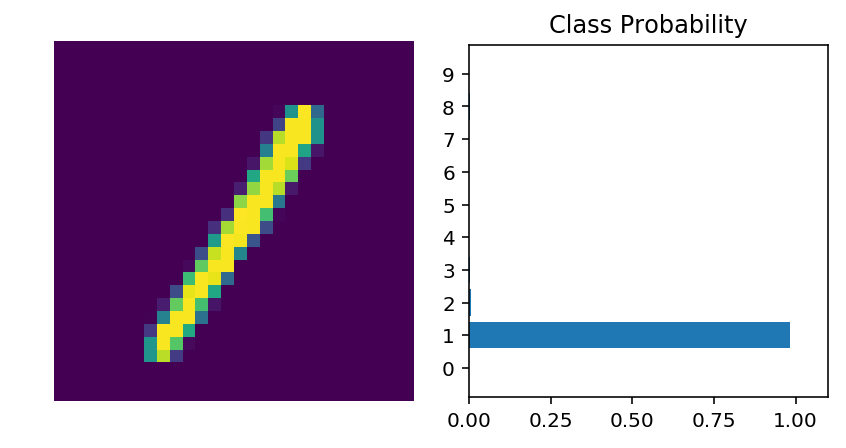

In [41]:
images, labels = next(iter(trainloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logits = model.forward(img)

# Output of the network are logits, need to take softmax for probabilities
ps = F.softmax(logits, dim=1)
helper.view_classify(img.view(1, 28, 28), ps)

Now our network is brilliant. It can accurately predict the digits in our images. Next up you'll write the code for training a neural network on a more complex dataset.